Conditions for STIRAP
 1. The mixing angle θ(t) of Eq. (12) varies slowly (adiabatically). 
 2. The P pulse is negligible at the start of the pulse sequence (|θ| → 0 mod π). 
 3. The S pulse is negligible at the termination of the pulse sequence (jθj → π∕2 mod π). 
 4. The two-photon detuning remains zero, i.e., δ = 0. 
 5. The single-photon detuning Δ is constant (optimally zero). 

In [1]:
%matplotlib inline

In [2]:
from numpy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import time

from physconsts import *
from rbconsts import *
from amophys import cc

In [24]:
#### functions 

def derivs(y0,t,O1,O2,D1,D2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    r11,r12,r13,r22,r23,r33 = y0
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

def runsim(func, idx=0, t_exp=60, tcentered=False):
    """ func is the derivs function
        idx is the index of the unraveled density matrix where 
            the population starts
        t_exp is experiment duration. t_2pi = 2*pi/w_rabi for 
            the simple three-level system
    """
    dt = 0.01 # timestep for DE solver
    t = arange(t_exp,step=dt)
    if tcentered == True:
        t -= t_exp/2
    tspan = [t[0],t[-1]]

    y0 = zeros(6, complex)
    y0[0] = 1 + 0j # all population in ground state rho11

    return solve_ivp(func,tspan,y0,t_eval=t)#linspace(0,t_exp,400))

# # the dressed states
# psi_1 = lambda

In [99]:
#### parameters for coherent |g> <--> |r> oscillation 
# w = 1 # doesn't matter here
# t2 = 1 # doesn't matter here
# t1 = t2 + 5 # doesn't matter here
# O2 = lambda t: 2*pi*1 #exp(-((t-t2)/w)**2/2) # arb units
# O1 = lambda t: 2*pi*1 #exp(-((t-t1)/w)**2/2)
# D1 = 2*pi*10 # arb units
# D2 = lambda t: -D1# + (O1(t)**2 - O2(t)**2)/4*D1

#### parameters for stirap maybe
w = 10
dt = 20
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0

In [100]:
# func = lambda y,t: derivs(t,y,O1(t),O2(t),D1,D2(t))
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

soln = runsim(func, t_exp=120, tcentered=True)

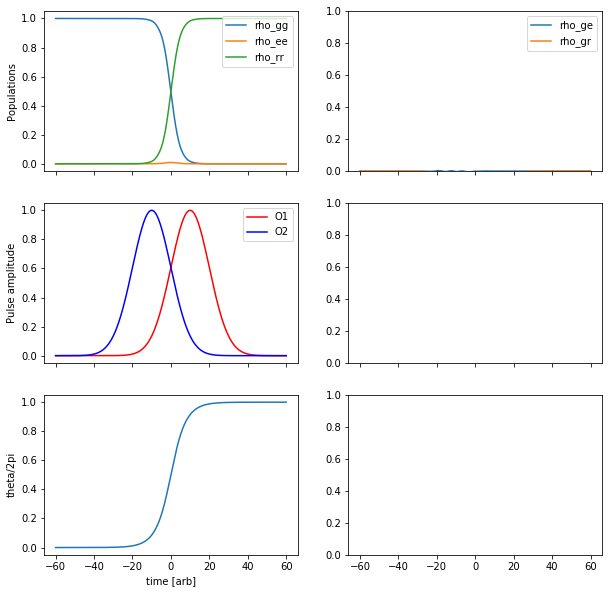

In [147]:
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex=True)
fig.figsize = (20,20)
unit = 1 #2*pi # divide

# populations -- interaction basis {|g>,|e>,|r>}
# ax[0][0].set_title('Population evolution w/o spontaneous emission')
ax[0][0].set_ylabel('Populations')
for i,l in zip([0,3,5],['rho_gg','rho_ee','rho_rr']):
    ax[0][0].plot(soln.t/unit,soln.y[i],label=l)
ax[0][0].legend(loc='upper right')

# rabi frequency
ax[1][0].set_ylabel('Pulse amplitude')
ax[1][0].plot(soln.t,O1(soln.t)/Omax,c='r',label='O1')
ax[1][0].plot(soln.t,O2(soln.t)/Omax,c='b',label='O2')
ax[1][0].legend(loc='upper right')

# mixing angle
ax[2][0].set_ylabel('theta/2pi')
ax[2][0].plot(soln.t, arctan(O1(soln.t)/O2(soln.t))/(pi/2))
ax[2][0].set_xlabel('time [arb]')

# populations in dressed basis {|B+>,|D>,|B->}
# coherences
for i,l in zip([1,2],['rho_ge', 'rho_gr']):
    ax[0][1].plot(soln.t,soln.y[i], label=l)
ax[0][1].set_ylim((0,1))
ax[0][1].legend(loc='upper right')

plt.show()

In [140]:
def psi_dressed(rho, Omega1, Omega2, Delta1, dim=3):
    """ return ndarray mod squared amplitudes of dressed states given the 
        corresponding density matrix for the 'regular' states (?)
        
        'rho': list of non-redundant elements of 3x3 density matrix for
            each solution timestep. i.e.: 
            rho = [[r11(t1)..r11(tN)],[r12(t1)..r12(tN)],...[r33(t1)..r33(tN)]]
            len(rho) = 6
            The returned ndarray will have the same form.
        'Omega1,2': array of field amplitudes at each solution timestep
        'Delta1': single photon detuning; scalar
    """
    
    assert len(rho) == 6
    assert len(Omega1) == len(rho[0])
    assert len(Omega1) == len(Omega2)
    
    gg,ge,gr,ee,er,rr = rho
    
    phi = .5*arctan(sqrt(Omega1**2 + Omega2**2)/Delta1)
    theta = tan(Omega1/Omega2)
    
    psi1 = gg*cos(theta)**2 - cos(theta)*sin(theta)*(cc(gr)+gr) + rr*sin(theta)**2 # |<psi|D>|^2
    psi2 = 0 #gg*cos(theta)**2 - rr*sin(theta)**2
    psi3 = 0 #gg*(sin(theta)*cos(phi))**2 + ee*(sin(phi))**2 + rr*(cos(theta)*cos(phi))**2
    
    return psi1,psi2,psi3

In [141]:
dressed = psi_dressed(soln.y, O1(soln.t), O2(soln.t), D1)

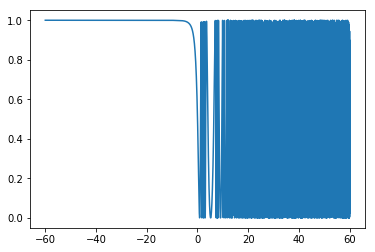

In [142]:
# for psi in dressed:
plt.plot(soln.t, dressed[0])

In [114]:
len(tan(O1(soln.t))**2)

12000